In [19]:
################################################################################
# A/L STREAM CLASSIFICATION - ADVANCED PIPELINE FOR HIGH ACCURACY
################################################################################

In [ ]:
# ========================== 1. IMPORTS ========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Core scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Ensemble
from sklearn.ensemble import StackingClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
# ========================== 2. DATA LOADING / CLEANING =========================

data = pd.read_csv("updated_dataset.csv")

print("Initial Shape:", data.shape)

# OPTIONAL: Drop duplicates
data.drop_duplicates(inplace=True)

# Identify missing values
missing_count = data.isnull().sum()
print("\nMissing values in each column:\n", missing_count)

data.dropna(axis=0, inplace=True)

print("Shape after dropping missing rows:", data.shape)

Initial Shape: (634, 13)

Missing values in each column:
 Stream                                         0
Did everything go well with your A/L exams?    0
Maths                                          0
Science                                        0
Religion                                       0
English                                        0
Sinhala or Tamil                               0
History                                        0
Basket I                                       0
Basket II                                      0
Basket III                                     0
Favorite Subject                               0
Career                                         0
dtype: int64
Shape after dropping missing rows: (534, 13)


In [22]:
# ========================== 3. DEFINE GRADE MAPPING ===========================
# O/L Grades often have an ordinal relationship: A > B > C > S > W
grade_mapping = {
    'A': 5,
    'B': 4,
    'C': 3,
    'S': 2,
    'W': 1,
}

In [23]:
# ========================== 4. MAP O/L COLUMNS ================================
# Example columns that are letter grades
grade_cols = [
    "Maths", "Science", "Religion", "English",
    "Sinhala or Tamil", "History",
    "Basket I", "Basket II", "Basket III"
]

# Convert them if they exist in the dataset
for gc in grade_cols:
    if gc in data.columns:
        data[gc] = data[gc].map(grade_mapping)

# We assume the target column is 'Stream'
target_col = "Stream"

# Identify possible categorical columns that are NOT the grade columns or the target
possible_cat_cols = ["Favorite Subject", "Career", "OtherCategorical1", "OtherCategorical2"]
cat_cols = [c for c in possible_cat_cols if c in data.columns]

# Numeric columns: the grade columns we mapped + any other numeric fields you want
numeric_cols = [c for c in grade_cols if c in data.columns]

In [24]:
# ========================== 5. SPLIT DATA =====================================
X = data[numeric_cols + cat_cols]
y = data[target_col]

# For classification, we do a stratified split (helps preserve class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# ========================== 6. BUILD PREPROCESSING PIPELINE ===================
# a) Numeric pipeline
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # or "median"
    ("scaler", StandardScaler())
])

# b) Categorical pipeline
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# c) ColumnTransformer that applies numeric_transformer to numeric_cols
#    and categorical_transformer to cat_cols
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [26]:
# ========================== 7. BUILD ENSEMBLE (STACKING) MODEL ===============
# We'll combine:
# 1) RandomForestClassifier
# 2) XGBClassifier
# 3) LogisticRegression
# As base learners in a StackingClassifier.

# Each base learner can have different hyperparams. We'll do a short grid search
# for illustration, but you can expand param_grid with more extensive combos.

estimators = [
    ("rf", RandomForestClassifier(random_state=42)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)),
    ("lr", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
]

# The final meta-learner can be another classifier or any classifier you want.
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
)

# Build a pipeline that first preprocesses, then fits the stacking ensemble
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("stack", stack_clf)
])

In [27]:
# ========================== 8. DEFINE A PARAM GRID FOR TUNING =================
param_grid = {
    # Example: Tuning n_estimators of the random forest
    "stack__rf__n_estimators": [100, 200],
    "stack__rf__max_depth": [None, 5],
    # Example: Tuning the XGB learning rate
    "stack__xgb__learning_rate": [0.1, 0.01],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # 5-fold cross validation
    scoring="accuracy",   # or "f1_weighted", "f1_macro" depending on class distribution
    n_jobs=-1,            # use all cores
    verbose=1
)

In [28]:
# ========================== 9. FIT THE MODEL ==================================
print("Fitting the stacking classifier with GridSearchCV...")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Fitting the stacking classifier with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\thenu\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [02:26:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\thenu\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [02:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\thenu\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [02:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Best parameters: {'stack__rf__max_depth': None, 'stack__rf__n_estimators': 200, 'stack__xgb__learning_rate': 0.1}
Best CV accuracy: 0.7914911080711354



Classification Report (Test Set):
                  precision    recall  f1-score   support

            Arts       0.82      0.69      0.75        13
     Bio Science       1.00      0.43      0.60        21
        Commerce       0.75      0.64      0.69        14
Physical Science       0.75      0.98      0.85        45
      Technology       0.75      0.86      0.80        14

        accuracy                           0.78       107
       macro avg       0.81      0.72      0.74       107
    weighted avg       0.81      0.78      0.76       107

Confusion Matrix (Test Set):
[[ 9  0  3  0  1]
 [ 1  9  0 10  1]
 [ 1  0  9  3  1]
 [ 0  0  0 44  1]
 [ 0  0  0  2 12]]


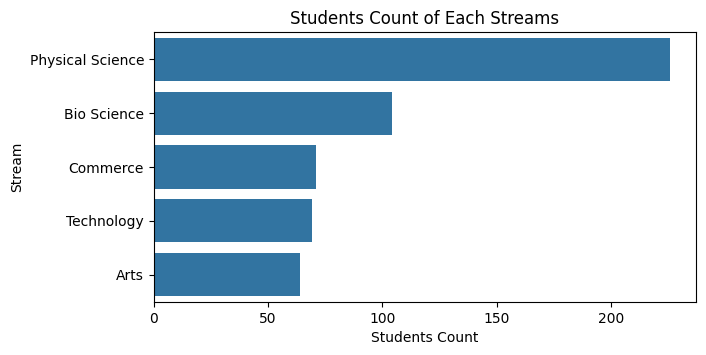

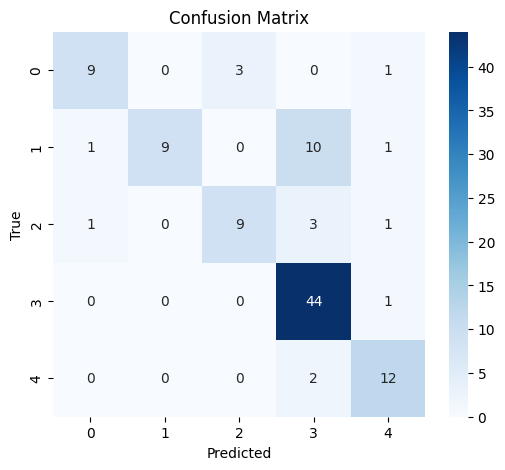

In [34]:
# ========================== 10. EVALUATE ON TEST ==============================
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot 1: Count of each degree:
plt.figure(figsize=(7, 3.5))
sns.countplot(y='Stream', data=data, order = data['Stream'].value_counts().index)
plt.title('Students Count of Each Streams')
plt.xlabel('Students Count')
plt.ylabel('Stream')
plt.show()

# Plot 2: Heatmap of the confusion matrix:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [35]:
# ========================== 11. EXAMPLE PREDICTION FUNCTION ===================
def predict_al_stream(model, user_inputs: dict):
    """
    Given the trained pipeline model and a dictionary of user inputs
    (matching the columns used in X), return the predicted stream.
    """
    # Convert to DataFrame
    user_df = pd.DataFrame([user_inputs])
    return model.predict(user_df)[0]

In [ ]:
# ========================== 12. SUCCESS PREDICTION FUNCTION ===================
def predict_success_probability(user_inputs: dict):
    """
    Predicts the probability of getting good A/L results based on similar past students.
    Returns:
        - success_percentage: % of similar students who reported "Yes, everything went well"
        - similar_count: Number of similar students in the dataset
    """
    # Convert user inputs to DataFrame
    user_df = pd.DataFrame([user_inputs])
    
    # 1. Find similar students (using Euclidean distance on numeric features)
    from sklearn.metrics.pairwise import euclidean_distances
    
    # Preprocess user input same as training data
    processed_input = preprocessor.transform(user_df)
    
    # Preprocess training data (if not already)
    X_train_processed = preprocessor.transform(X_train)
    
    # Calculate distances to all training samples
    distances = euclidean_distances(processed_input, X_train_processed)[0]
    
    # Get indices of the 50 most similar students
    similar_indices = np.argsort(distances)[:50]
    similar_students = data.iloc[similar_indices]
    
    # 2. Calculate success percentage
    success_counts = similar_students['Did everything go well with your A/L exams?'].value_counts(normalize=True) * 100
    success_percentage = success_counts.get("Yes, everything went well", 0)
    similar_count = len(similar_indices)
    
    return success_percentage, similar_count

In [37]:
# ========================== 13. ENHANCED PREDICTION FUNCTION =================
def enhanced_predict(model, user_inputs: dict):
    """
    Enhanced prediction that returns:
    - Predicted stream
    - Confidence score
    - Success probability
    - Similar student count
    """
    # 1. Get stream prediction
    predicted_stream = predict_al_stream(model, user_inputs)
    
    # 2. Get probabilities
    user_df = pd.DataFrame([user_inputs])
    class_probabilities = model.predict_proba(user_df)[0]
    confidence = np.max(class_probabilities)
    
    # 3. Get success probability
    success_percentage, similar_count = predict_success_probability(user_inputs)
    
    return {
        "predicted_stream": predicted_stream,
        "confidence": float(confidence),
        "success_probability": float(success_percentage),
        "similar_students_count": int(similar_count),
        "interpretation": f"Based on {similar_count} similar past students, {success_percentage:.1f}% achieved good A/L results"
    }

In [38]:
# ========================== 14. STREAM MAPPING ==========================
model_data = {
    "model": best_model,
    "preprocessor": preprocessor,
    "stream_mapping": {
        0: "Arts",
        1: "Bio Science",
        2: "Commerce",
        3: "Physical Science",
        4: "Technology"
    },
    "X_train": X_train,  # Needed for similarity comparison
    "data": data         # Original data with A_L_Result column
}

In [39]:
# ========================== 15. EXAMPLE USAGE ================================
# First ensure preprocessor is fitted (add this if not already done)
preprocessor.fit(X_train)  # X_train should be your training data

# Define possible values (use actual values from your data)
possible_grades = [1, 2, 3, 4, 5]  # Numeric mapped grades (1=W, 5=A)
possible_fav_subjects = data['Favorite Subject'].unique().tolist()
possible_careers = data['Career'].unique().tolist()

# Generate random sample
example_input = {
    "Maths": 5,  # user got 'A'
    "Science": 3,  # user got 'C'
    "Religion": 5,  # user got 'A'
    "English": 4,  # user got 'B'
    "Sinhala or Tamil": 5,  # user got 'A'
    "History": 3,  # user got 'C'
    "Basket I": 4,  # 'B'
    "Basket II": 3, # 'C'
    "Basket III": 5, # 'A'
    "Favorite Subject": "Sinhala",
    "Career": "Other"
}

# Get prediction
result = enhanced_predict(best_model, example_input)
print("\nPrediction Results:")
for key, value in result.items():
    print(f"{key:>25}: {value}")


Prediction Results:
         predicted_stream: Technology
               confidence: 0.6732852182352119
      success_probability: 40.0
   similar_students_count: 50
           interpretation: Based on 50 similar past students, 40.0% achieved good A/L results


In [42]:
# ========================== 16. MODEL SAVING ================================
import joblib

joblib.dump(model_data, 'model.pkl')

['model.pkl']